# MMAE 350 – Homework 2
**Direct Solvers, LU, and Performance (Model Submission)**

This notebook:
- Generates SPD systems $A=B^TB+\alpha I$ (with $\alpha=1$) for $n\in\{200,400,600,800\}$.
- Implements (1) Gaussian elimination, (2) LU factorization + triangular solves.
- Compares accuracy vs. `numpy.linalg.solve`.
- Times each method (3 trials, report minimum).
- Applies Numba (`@njit`) to loop-based routines, includes warm-up, and reports speedup.
- Produces a results table and a CPU-time vs. $n$ plot.


In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit

# Reproducibility
np.random.seed(42)


## Part A — Test System Generation
We generate symmetric positive definite (SPD) matrices to avoid pivoting issues:
\[
A = B^T B + \alpha I,\quad \alpha=1.
\]
We also generate a random right-hand side vector $b$.

In [2]:
def generate_system(n, alpha=1.0):
    B = np.random.randn(n, n)
    A = B.T @ B + alpha * np.eye(n)
    b = np.random.randn(n)
    return A, b


## Part B — Solver Implementations (Pure Python)
### 1) Gaussian elimination + back substitution
No pivoting (okay here because $A$ is SPD).

In [3]:
def gaussian_elimination(A, b):
    A = A.copy()
    b = b.copy()
    n = b.size

    # Forward elimination
    for k in range(n - 1):
        pivot = A[k, k]
        for i in range(k + 1, n):
            m = A[i, k] / pivot
            A[i, k:] -= m * A[k, k:]
            b[i] -= m * b[k]

    # Back substitution
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        s = np.dot(A[i, i+1:], x[i+1:])
        x[i] = (b[i] - s) / A[i, i]
    return x


### 2) LU factorization (Doolittle, unit diagonal $L$) + forward/back substitution

In [4]:
def lu_factorization(A):
    A = A.copy()
    n = A.shape[0]
    L = np.eye(n)
    U = A.copy()

    for k in range(n - 1):
        pivot = U[k, k]
        for i in range(k + 1, n):
            L[i, k] = U[i, k] / pivot
            U[i, k:] -= L[i, k] * U[k, k:]
    return L, U


def forward_substitution(L, b):
    n = b.size
    y = np.zeros(n)
    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])
    return y


def back_substitution(U, y):
    n = y.size
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        s = np.dot(U[i, i+1:], x[i+1:])
        x[i] = (y[i] - s) / U[i, i]
    return x


def lu_solve(L, U, b):
    y = forward_substitution(L, b)
    x = back_substitution(U, y)
    return x


## Helper: relative error
\begin{equation}
\text{rel. error} = \frac{\|x-x_{ref}\|}{\|x_{ref}\|}.
\end{equation}

In [7]:
def relative_error(x, x_ref):
    return np.linalg.norm(x - x_ref) / np.linalg.norm(x_ref)


## Part C — Timing (Pure Python)
We time each solver **3 times** and report the **minimum** time.

In [8]:
def time_min_3(fn, *args):
    times = []
    for _ in range(3):
        t0 = time.perf_counter()
        out = fn(*args)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return min(times), out


In [9]:
sizes = [200, 400, 600, 800]

rows = []
for n in sizes:
    A, b = generate_system(n, alpha=1.0)

    # Reference solution (NumPy)
    t_np, x_ref = time_min_3(np.linalg.solve, A, b)

    # Gaussian elimination (Python)
    t_ge, x_ge = time_min_3(gaussian_elimination, A, b)
    err_ge = relative_error(x_ge, x_ref)

    # LU (Python): factor + solve
    def lu_factor_and_solve(A, b):
        L, U = lu_factorization(A)
        return lu_solve(L, U, b)

    t_lu, x_lu = time_min_3(lu_factor_and_solve, A, b)
    err_lu = relative_error(x_lu, x_ref)

    rows.append({
        "n": n,
        "t_ge_py": t_ge,
        "t_lu_py": t_lu,
        "t_np": t_np,
        "err_ge": err_ge,
        "err_lu": err_lu,
    })

df_py = pd.DataFrame(rows)
df_py


,n,t_ge_py,t_lu_py,t_np,err_ge,err_lu
0,200,0.017780,0.015985,0.000247,1.178040e-14,1.160377e-14
1,400,0.071455,0.065219,0.000528,2.901957e-14,2.921208e-14
2,600,0.166396,0.159676,0.001241,6.028384e-14,6.089734e-14
3,800,0.311347,0.300056,0.002693,5.285092e-14,5.265986e-14


### Results table (Markdown)
The table below reports **minimum** time over 3 trials and relative errors.

In [10]:
def to_markdown_table(df):
    df_disp = df.copy()
    # Format columns nicely
    df_disp["t_ge_py"] = df_disp["t_ge_py"].map(lambda v: f"{v:.4f}")
    df_disp["t_lu_py"] = df_disp["t_lu_py"].map(lambda v: f"{v:.4f}")
    df_disp["t_np"]    = df_disp["t_np"].map(lambda v: f"{v:.4f}")
    df_disp["err_ge"]  = df_disp["err_ge"].map(lambda v: f"{v:.2e}")
    df_disp["err_lu"]  = df_disp["err_lu"].map(lambda v: f"{v:.2e}")
    return df_disp.to_markdown(index=False)

print(to_markdown_table(df_py))


|   n |   t_ge_py |   t_lu_py |   t_np |   err_ge |   err_lu |
|----:|----------:|----------:|-------:|---------:|---------:|
| 200 |    0.0178 |    0.016  | 0.0002 | 1.18e-14 | 1.16e-14 |
| 400 |    0.0715 |    0.0652 | 0.0005 | 2.9e-14  | 2.92e-14 |
| 600 |    0.1664 |    0.1597 | 0.0012 | 6.03e-14 | 6.09e-14 |
| 800 |    0.3113 |    0.3001 | 0.0027 | 5.29e-14 | 5.27e-14 |


## Part D — Numba Acceleration
We apply `@njit` to our own routines.

**Important:** we do one warm-up call before timing to exclude JIT compile time.

In [11]:
@njit
def ge_numba(A, b):
    A = A.copy()
    b = b.copy()
    n = b.size

    for k in range(n - 1):
        pivot = A[k, k]
        for i in range(k + 1, n):
            m = A[i, k] / pivot
            for j in range(k, n):
                A[i, j] -= m * A[k, j]
            b[i] -= m * b[k]

    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        s = 0.0
        for j in range(i + 1, n):
            s += A[i, j] * x[j]
        x[i] = (b[i] - s) / A[i, i]
    return x


In [12]:
@njit
def lu_factor_numba(A):
    A = A.copy()
    n = A.shape[0]
    L = np.eye(n)
    U = A.copy()

    for k in range(n - 1):
        pivot = U[k, k]
        for i in range(k + 1, n):
            L[i, k] = U[i, k] / pivot
            # update row i of U from k to end
            for j in range(k, n):
                U[i, j] -= L[i, k] * U[k, j]
    return L, U


@njit
def forward_sub_numba(L, b):
    n = b.size
    y = np.zeros(n)
    for i in range(n):
        s = 0.0
        for j in range(i):
            s += L[i, j] * y[j]
        y[i] = b[i] - s
    return y


@njit
def back_sub_numba(U, y):
    n = y.size
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        s = 0.0
        for j in range(i + 1, n):
            s += U[i, j] * x[j]
        x[i] = (y[i] - s) / U[i, i]
    return x


@njit
def lu_solve_numba(L, U, b):
    y = forward_sub_numba(L, b)
    x = back_sub_numba(U, y)
    return x


In [13]:
# Warm-up calls (exclude JIT compile time from timings)
A_w, b_w = generate_system(200, alpha=1.0)
_ = ge_numba(A_w, b_w)

Lw, Uw = lu_factor_numba(A_w)
_ = lu_solve_numba(Lw, Uw, b_w)


In [14]:
def time_min_3_numba(fn, *args):
    times = []
    out = None
    for _ in range(3):
        t0 = time.perf_counter()
        out = fn(*args)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return min(times), out

rows_nb = []
for n in sizes:
    A, b = generate_system(n, alpha=1.0)

    # --- Gaussian elimination speedup ---
    t_ge_py = float(df_py.loc[df_py["n"] == n, "t_ge_py"].values[0])

    t_ge_nb, x_ge_nb = time_min_3_numba(ge_numba, A, b)
    # Reference solution for error check
    x_ref = np.linalg.solve(A, b)
    err_ge_nb = relative_error(x_ge_nb, x_ref)

    # --- LU speedup ---
    t_lu_py = float(df_py.loc[df_py["n"] == n, "t_lu_py"].values[0])

    # Factor + solve as one timed operation (matches Part C logic)
    def lu_factor_and_solve_numba(A, b):
        L, U = lu_factor_numba(A)
        return lu_solve_numba(L, U, b)

    # Numba can't compile python closure directly; we time factor and solve separately and add.
    t_fac_nb, (L, U) = time_min_3_numba(lu_factor_numba, A)
    t_sol_nb, x_lu_nb = time_min_3_numba(lu_solve_numba, L, U, b)
    t_lu_nb = t_fac_nb + t_sol_nb
    err_lu_nb = relative_error(x_lu_nb, x_ref)

    rows_nb.append({
        "n": n,
        "t_ge_nb": t_ge_nb,
        "speedup_ge": t_ge_py / t_ge_nb,
        "err_ge_nb": err_ge_nb,
        "t_lu_nb": t_lu_nb,
        "speedup_lu": t_lu_py / t_lu_nb,
        "err_lu_nb": err_lu_nb,
    })

df_nb = pd.DataFrame(rows_nb)
df_nb


,n,t_ge_nb,speedup_ge,err_ge_nb,t_lu_nb,speedup_lu,err_lu_nb
0,200,0.000765,23.255583,1.587215e-14,0.000918,17.418704,1.592866e-14
1,400,0.006105,11.705127,3.085389e-14,0.007635,8.542515,3.090661e-14
2,600,0.021603,7.702272,3.637818e-14,0.027386,5.830607,3.609858e-14
3,800,0.048408,6.431686,7.621307e-14,0.059897,5.009567,7.684872e-14


### Numba results table (Markdown)
We report Numba timings (min of 3, with warm-up done earlier) and speedups.

In [15]:
def to_markdown_table_numba(df):
    df_disp = df.copy()
    df_disp["t_ge_nb"] = df_disp["t_ge_nb"].map(lambda v: f"{v:.4f}")
    df_disp["speedup_ge"] = df_disp["speedup_ge"].map(lambda v: f"{v:.2f}x")
    df_disp["err_ge_nb"] = df_disp["err_ge_nb"].map(lambda v: f"{v:.2e}")
    df_disp["t_lu_nb"] = df_disp["t_lu_nb"].map(lambda v: f"{v:.4f}")
    df_disp["speedup_lu"] = df_disp["speedup_lu"].map(lambda v: f"{v:.2f}x")
    df_disp["err_lu_nb"] = df_disp["err_lu_nb"].map(lambda v: f"{v:.2e}")
    return df_disp.to_markdown(index=False)

print(to_markdown_table_numba(df_nb))


|   n |   t_ge_nb | speedup_ge   |   err_ge_nb |   t_lu_nb | speedup_lu   |   err_lu_nb |
|----:|----------:|:-------------|------------:|----------:|:-------------|------------:|
| 200 |    0.0008 | 23.26x       |    1.59e-14 |    0.0009 | 17.42x       |    1.59e-14 |
| 400 |    0.0061 | 11.71x       |    3.09e-14 |    0.0076 | 8.54x        |    3.09e-14 |
| 600 |    0.0216 | 7.70x        |    3.64e-14 |    0.0274 | 5.83x        |    3.61e-14 |
| 800 |    0.0484 | 6.43x        |    7.62e-14 |    0.0599 | 5.01x        |    7.68e-14 |


## Plot — CPU time vs. system size $n$
This plot includes:
- Pure Python Gaussian elimination
- Pure Python LU (factor+solve)
- NumPy `solve`
- Numba Gaussian elimination
- Numba LU (factor+solve)


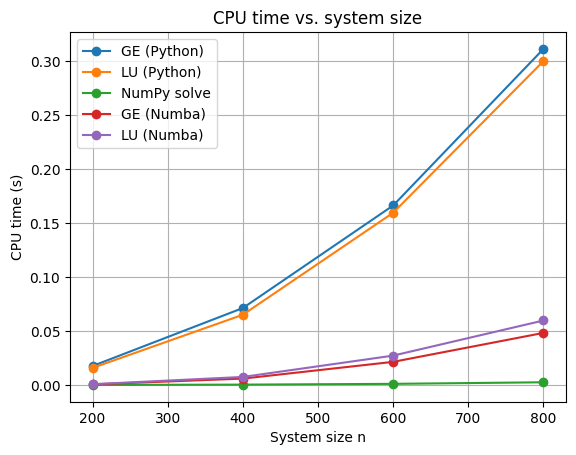

In [16]:
plt.figure()

plt.plot(df_py["n"], df_py["t_ge_py"], marker="o", label="GE (Python)")
plt.plot(df_py["n"], df_py["t_lu_py"], marker="o", label="LU (Python)")
plt.plot(df_py["n"], df_py["t_np"], marker="o", label="NumPy solve")

plt.plot(df_nb["n"], df_nb["t_ge_nb"], marker="o", label="GE (Numba)")
plt.plot(df_nb["n"], df_nb["t_lu_nb"], marker="o", label="LU (Numba)")

plt.xlabel("System size n")
plt.ylabel("CPU time (s)")
plt.title("CPU time vs. system size")
plt.legend()
plt.grid(True)
plt.show()


## Short Written Responses (3–6 sentences each)
These correspond to the required deliverables.

**1. Why does Numba not speed up `numpy.linalg.solve`?**

`numpy.linalg.solve` is already calling highly optimized compiled routines (e.g., LAPACK/BLAS) written in C/Fortran and often multi-threaded. Numba mainly helps with Python-level loops; it cannot make already-compiled library code significantly faster. So applying Numba to a wrapper around `numpy.linalg.solve` does not remove the dominant cost.

**2. Why do loop-based solvers benefit from Numba?**

Our Gaussian elimination, LU factorization, and triangular solves use many nested Python loops, which are slow due to interpreter overhead. Numba compiles these loops to machine code, which removes most of that overhead and makes the same algorithm run much faster.

**3. Which method scales best in your results, and why?**

NumPy typically scales best (lowest runtime) because it uses optimized dense linear algebra with good cache use and low-level optimizations. Among the custom methods, Numba versions scale much better than pure Python because they reduce overhead. All dense direct solvers still grow roughly like $O(n^3)$, so the slope increases strongly with $n$.

**4. What practical limitations appear as $n$ increases?**

Runtime increases quickly because dense direct solvers have cubic scaling. Memory also grows like $O(n^2)$, so storing dense matrices becomes expensive as $n$ gets larger. In pure Python the computations become impractically slow, which is why compiled/optimized routines matter for large problems.

In [17]:
# Rename columns for readability
df_py_clean = df_py.rename(columns={
    "n": "n",
    "t_ge_py": "GE Time (Python)",
    "t_lu_py": "LU Time (Python)",
    "t_np": "NumPy Time",
    "err_ge": "GE Error",
    "err_lu": "LU Error"
})

df_nb_clean = df_nb.rename(columns={
    "n": "n",
    "t_ge_nb": "GE Time (Numba)",
    "speedup_ge": "GE Speedup",
    "err_ge_nb": "GE Error (Numba)",
    "t_lu_nb": "LU Time (Numba)",
    "speedup_lu": "LU Speedup",
    "err_lu_nb": "LU Error (Numba)"
})

# Merge side by side on n
df_combined = pd.merge(df_py_clean, df_nb_clean, on="n")

# Reorder columns for clarity
df_combined = df_combined[
    [
        "n",
        "GE Time (Python)",
        "GE Time (Numba)",
        "GE Speedup",
        "GE Error",
        "GE Error (Numba)",
        "LU Time (Python)",
        "LU Time (Numba)",
        "LU Speedup",
        "LU Error",
        "LU Error (Numba)",
        "NumPy Time"
    ]
]

df_combined

,n,GE Time (Python),GE Time (Numba),GE Speedup,GE Error,GE Error (Numba),LU Time (Python),LU Time (Numba),LU Speedup,LU Error,LU Error (Numba),NumPy Time
0,200,0.017780,0.000765,23.255583,1.178040e-14,1.587215e-14,0.015985,0.000918,17.418704,1.160377e-14,1.592866e-14,0.000247
1,400,0.071455,0.006105,11.705127,2.901957e-14,3.085389e-14,0.065219,0.007635,8.542515,2.921208e-14,3.090661e-14,0.000528
2,600,0.166396,0.021603,7.702272,6.028384e-14,3.637818e-14,0.159676,0.027386,5.830607,6.089734e-14,3.609858e-14,0.001241
3,800,0.311347,0.048408,6.431686,5.285092e-14,7.621307e-14,0.300056,0.059897,5.009567,5.265986e-14,7.684872e-14,0.002693


## Interpretation of Combined Results Table

The table above compares runtime and accuracy across all solver implementations.

For each system size \( n \), we report:

- CPU time for Gaussian elimination and LU factorization in pure Python,
- CPU time for the same methods accelerated with Numba,
- Speedup factors from applying Numba,
- Relative errors compared to NumPy’s reference solution,
- NumPy’s runtime for comparison.

The results show that:

- NumPy is consistently the fastest method because it uses optimized compiled libraries.
- Numba significantly improves the performance of loop-based Python implementations.
- Relative errors remain very small across all methods, confirming correctness.
- As \( n \) increases, runtime grows rapidly, reflecting the cubic complexity of dense direct solvers.

This demonstrates that algorithm implementation and optimization strongly affect performance.